In [1]:
import sys
from collections import namedtuple
import pandas as pd
import numpy as np
from rdkit import rdBase, Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, PandasTools, rdMolDescriptors, QED, rdmolops, MolFromSmarts
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.SpacialScore import SPS
from rdkit.Chem.rdMolDescriptors import CalcNumRings, CalcNumSpiroAtoms, CalcNumBridgeheadAtoms
from rdkit.Chem.rdmolops import GetSymmSSSR
import QEPPI as ppi
import sascorer

PandasTools.RenderImagesInAllDataFrames(True)
from rdkit.Chem.Draw import IPythonConsole

import mols2grid
import useful_rdkit_utils as uru

import math
from scipy.stats import pearsonr, spearmanr
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

print(sys.version)
print(rdBase.rdkitVersion)

3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0]
2025.03.1


In [2]:
# Calculates the SpacialScore descriptor
#https://github.com/frog2000/Spacial-Score
def compute_spacial_score(mol, normalize=True):
    try:
        if mol is None:
            return None
        return SPS(mol, normalize=normalize)
    except Exception as e:
        print(f"Error processing molecule: {e}")
        return None

In [3]:
q = ppi.QEPPI_Calculator()
print("QEPPI.model LOADING...")
q.load("./QEPPI/QEPPI.model")

QEPPI.model LOADING...


In [4]:
#Calculating NP_Score
import npscorer
fscore = npscorer.readNPModel()

reading NP model ...
model in


In [5]:
#calculate the number of macrocycle
def get_num_macrocycles(mol, min_ring_size=12):
    """
    Returns the number of rings in the molecule that contain at least `min_ring_size` atoms.
    This function uses RDKit's symmetric SSSR method to detect rings.

    Args:
        mol (Chem.Mol): An RDKit molecule object.
        min_ring_size (int): The minimum ring size to be considered a macrocycle (default is 12).

    Returns:
        int: The number of macrocycles (i.e., rings with size >= min_ring_size).
    """
    if mol is None:
        return 0

    # Get the "Symmetrical SSSR" ring set from RDKit
    sssr = Chem.GetSymmSSSR(mol)

    count = 0
    for ring in sssr:
        if len(ring) >= min_ring_size:
            count += 1

    return count

In [6]:
# calculate the number of isolated rings
def calculate_nIR(mol):
    """
    Calculate the number of isolated rings (nIR) in a molecule.
    
    Parameters:
        mol (rdkit.Chem.Mol): RDKit molecule object.

    Returns:
        int: Number of isolated rings.
    """
    if mol is None:
        return None

    # Get the rings as a list of sets of atom indices
    sssr = rdmolops.GetSymmSSSR(mol)
    ring_list = [set(ring) for ring in sssr]
    
    # Identify isolated rings
    isolated_rings = 0
    for i, ring_i in enumerate(ring_list):
        # Check if the ring shares any atom with any other ring
        is_isolated = all(ring_i.isdisjoint(ring_j) for j, ring_j in enumerate(ring_list) if i != j)
        if is_isolated:
            isolated_rings += 1
    
    return isolated_rings

# calculate the number of fused rings
def calculate_nFR(mol):
    """
    Calculate the number of fused rings (nFR) in a molecule.
    
    Parameters:
        mol (rdkit.Chem.Mol): RDKit molecule object.

    Returns:
        int: Number of fused rings.
    """
    if mol is None:
        return None

    sssr = rdmolops.GetSymmSSSR(mol)
    total_rings = len(sssr)
    nIR = calculate_nIR(mol)
    nFR = total_rings - nIR
    return nFR

# calculate the total ring size (TRS)
def calculate_TRS(mol):
    """
    Calculate the total ring size (TRS) in a molecule.
    
    Parameters:
        mol (rdkit.Chem.Mol): RDKit molecule object.

    Returns:
        int: Total ring size (sum of all ring sizes).
    """
    if mol is None:
        return None

    sssr = rdmolops.GetSymmSSSR(mol)
    total_ring_size = sum(len(ring) for ring in sssr)
    return total_ring_size

# calculate sum of all bonds forming the rings
def calculate_Rperim(mol):
    """
    Calculate the total ring perimeter (Rperim) in a molecule.
    
    Parameters:
        mol (rdkit.Chem.Mol): RDKit molecule object.

    Returns:
        int: Total ring perimeter (sum of all bonds forming the rings).
    """
    if mol is None:
        return None

    # Rperim is equivalent to TRS for the smallest set of rings
    return calculate_TRS(mol)

In [7]:
#Calculate the Number of Ring Systems (NRS)
def calculate_nrs(mol):
    """
    Calculate the Number of Ring Systems (NRS) for a given molecule.
    
    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object.
    
    Returns:
        int: Number of Ring Systems (NRS).
    """
    if mol is None:
        return None  # Return None for invalid molecules

    # Total number of bonds in the hydrogen-depleted molecular graph
    nBO = mol.GetNumBonds()
    
    # Total number of heavy atoms (non-hydrogen atoms) in the molecule
    nSK = mol.GetNumHeavyAtoms()
    
    # Number of bonds that belong to rings
    B_R = sum(bond.IsInRing() for bond in mol.GetBonds())
    
    # Number of atoms that belong to rings
    A_R = sum(atom.IsInRing() for atom in mol.GetAtoms())
    
    # Number of disjoint molecular substructures
    nStructures = len(rdmolops.GetMolFrags(mol, asMols=True))
    
    # Calculate NRS using the formula
    NRS = (nBO - B_R) - (nSK - A_R) + nStructures
    
    return NRS

In [8]:
#calculate Normalized Number of Ring Systems (NNRS)
def calculate_cyclomatic_number(mol):
    """
    Calculate the cyclomatic number (nCIC) for a given molecule.
    
    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object.
    
    Returns:
        int: Cyclomatic number (nCIC).
    """
    if mol is None:
        return None  # Return None for invalid molecules

    # Total number of bonds
    nBO = mol.GetNumBonds()
    
    # Total number of heavy atoms (non-hydrogen atoms) in the molecule
    nSK = mol.GetNumHeavyAtoms()
    
    # Number of disjoint substructures
    nStructures = len(rdmolops.GetMolFrags(mol, asMols=True))
    
    # Calculate cyclomatic number
    nCIC = nBO - nSK + nStructures
    return nCIC

def calculate_nnrs(mol):
    """
    Calculate the Normalized Number of Ring Systems (NNRS) for a given molecule.
    
    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object.
    
    Returns:
        float: Normalized Number of Ring Systems (NNRS).
    """
    if mol is None:
        return None  # Return None for invalid molecules

    # Calculate NRS
    nrs = calculate_nrs(mol)
    
    # Calculate nCIC (cyclomatic number)
    nCIC = calculate_cyclomatic_number(mol)
    
    # Avoid division by zero
    if nCIC is None or nCIC == 0:
        return None

    # Calculate NNRS
    nnrs = nrs / nCIC
    return nnrs

#Molecular Cyclized Degree (MCD)
def calculate_mcd(mol):
    """
    Calculate the Molecular Cyclized Degree (MCD) for a given molecule.
    
    Args:
        mol (rdkit.Chem.Mol): RDKit molecule object.
    
    Returns:
        float: Molecular Cyclized Degree (MCD) or None if calculation is not possible.
    """
    if mol is None:
        return None  # Return None for invalid molecules

    # Total number of non-hydrogen (skeleton) atoms
    nSK = mol.GetNumHeavyAtoms()

    # Number of atoms in rings
    nRingAtoms = sum(atom.IsInRing() for atom in mol.GetAtoms())

    # Avoid division by zero
    if nSK == 0:
        return None

    # Calculate MCD
    MCD = nRingAtoms / nSK
    return MCD

In [9]:
#calculate Ring Fusion Density (RFD)
def calculate_ring_fusion_density(mol):
    """
    Calculate the Ring Fusion Density (RFD) for a given RDKit molecule.
    
    Parameters:
        mol (rdkit.Chem.Mol): RDKit molecule object.
    
    Returns:
        float: Ring Fusion Density (RFD) = Fused Rings / Total Rings.
               Returns None if the molecule has no rings.
    """
    if mol is None:
        return None  # Skip invalid molecules
    
    # Get ring information
    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()  # List of rings (each as a tuple of atom indices)
    
    total_rings = len(atom_rings)
    if total_rings == 0:
        return None  # No rings in the molecule
    
    # Find fused rings (rings sharing at least one atom)
    fused_rings = 0
    for i, ring1 in enumerate(atom_rings):
        for j, ring2 in enumerate(atom_rings):
            if i < j and set(ring1).intersection(set(ring2)):  # Check if rings share any atoms
                fused_rings += 1
                break  # Count each ring only once
    
    # Calculate RFD
    rfd = fused_rings / total_rings
    return rfd

In [10]:
#calculate Aromatic Ratio (ARR)
def Calc_ARR(mol):
    """
    Calculate the Aromatic Ratio (ARR) for a given molecule.

    Parameters:
    mol: RDKit molecule object (with or without explicit hydrogens)

    Returns:
    float: Aromatic Ratio (ARR), defined as the ratio of aromatic bonds
           to total non-hydrogen bonds.
    """
    m = Chem.RemoveHs(mol)  # Remove explicit hydrogens to simplify bond counting
    num_bonds = m.GetNumBonds()
    if num_bonds == 0:
        return 0.0  # Handle edge case for molecules with no bonds
    num_aromatic_bonds = sum(1 for bond in m.GetBonds() if bond.GetIsAromatic())
    ARR = num_aromatic_bonds / num_bonds
    return round(ARR, 4)  # Return the result rounded to 4 decimal places


#Calculate the aromatic-sp3 carbon balance for a molecule.
def Calc_Ar_Alk_balance(mol):
    """
    Calculate the aromatic-sp3 carbon balance for a molecule.

    Parameters:
    mol: RDKit molecule object (with or without explicit hydrogens)

    Returns:
    int: Difference between the number of aromatic carbons and sp3 carbons.
    """
    m = Chem.RemoveHs(mol)
    num_aromatic_carbon = sum(1 for atom in m.GetAromaticAtoms() if atom.GetSymbol() == 'C')
    num_sp3_carbon = sum(1 for atom in m.GetAtoms() if atom.GetHybridization() == Chem.rdchem.HybridizationType.SP3 and atom.GetSymbol() == 'C')
    return num_aromatic_carbon - num_sp3_carbon

In [11]:
#Calculates the Ring Complexity Index
def calculate_ring_complexity_index(mol):
    """
    Calculate the Ring Complexity Index (RCI) for a molecule.

    Parameters:
        mol (rdkit.Chem.Mol): RDKit molecule object.

    Returns:
        float: Ring Complexity Index (RCI) or None if molecule is invalid.
    """
    if not mol:
        return None

    ring_info = mol.GetRingInfo()
    ring_sizes = [len(ring) for ring in ring_info.AtomRings()]
    
    # Calculate TRS (Total Ring Size) and nRingAtoms (number of ring atoms)
    TRS = sum(ring_sizes)
    nRingAtoms = len(set([atom for ring in ring_info.AtomRings() for atom in ring]))

    if nRingAtoms == 0:
        return 0  # Avoid division by zero

    # Calculate RCI
    RCI = TRS / nRingAtoms
    return RCI

In [12]:
# Function to calculate the ideal internal angle sum for a ring
def calculate_ideal_internal_angle_sum(ring_size):
    return (ring_size - 2) * 180 / ring_size

# Function to calculate Strain Factor (SF)
def calculate_strain_factor(mol, rings, lambda_macrocycle=0.5, macrocycle_threshold=12):
    """
    Calculates the strain factor (SF) while reducing its contribution for macrocycles (≥12-membered rings).
    """
    strain_factor = 0
    for ring in rings:
        ring_size = len(ring)
        ideal_angle_sum = calculate_ideal_internal_angle_sum(ring_size)
        
        # Apply macrocycle correction factor
        lambda_M = lambda_macrocycle if ring_size >= macrocycle_threshold else 1.0
        
        strain_factor += (360 / (360 - ideal_angle_sum)) / ring_size * lambda_M
    return strain_factor

# Calculate the number of macrocycles
def count_macrocycles(mol, min_ring_size=12):
    """
    Returns the number of rings in the molecule that contain at least `min_ring_size` atoms.
    This function uses RDKit's symmetric SSSR method to detect rings.

    Args:
        mol (Chem.Mol): An RDKit molecule object.
        min_ring_size (int): The minimum ring size to be considered a macrocycle (default is 12).

    Returns:
        int: The number of macrocycles (i.e., rings with size >= min_ring_size).
    """
    if mol is None:
        return 0

    # Get the "Symmetrical SSSR" ring set from RDKit
    sssr = Chem.GetSymmSSSR(mol)

    count = 0
    for ring in sssr:
        if len(ring) >= min_ring_size:
            count += 1

    return count

# calculate QRCI with normalization and entropy-based weight optimization
def calculate_QRCI(smiles_or_mol, weights=None, normalize=True, W_macro=2.0):
    """
    Calculate the QRCI (Quantitative Ring Complexity Index) with QEPP enhancements.
    """
    # Default weights if none are provided
    if weights is None:
        weights = (1.3, 0.9, 1.2, 0.9, 0.9, 1.1)

    # Ensure input is a valid RDKit molecule
    if isinstance(smiles_or_mol, str):
        mol = Chem.MolFromSmiles(smiles_or_mol)
        if mol is None:
            return None
    else:
        mol = smiles_or_mol

# Calculate ring information
    ri = mol.GetRingInfo()
    rings = ri.AtomRings()
    nRing = len(rings)

    # Return 0 if no rings are present
    if nRing == 0:
        return 0.0

    # Core descriptors
    TRS = sum(len(ring) for ring in rings)  # Total Ring Size
    nRingAtom = len(set(atom for ring in rings for atom in ring))
    nFusedRing = sum(1 for ring in rings if any(set(ring) & set(other) for other in rings if ring != other))
    SF = calculate_strain_factor(mol, rings)
    nTotalAtom = mol.GetNumAtoms()

    # Chemical diversity descriptors
    nAromHeteroRing = Descriptors.NumAromaticHeterocycles(mol)
    nAromaticCarbocycle = Descriptors.NumAromaticCarbocycles(mol)
    nAliphaticHeterocycle = Descriptors.NumAliphaticHeterocycles(mol)
    nAliphaticCarbocycle = Descriptors.NumAliphaticCarbocycles(mol)
    nSaturatedCarbocycle = Descriptors.NumSaturatedCarbocycles(mol)
    nSaturatedHeterocycle = Descriptors.NumSaturatedHeterocycles(mol)
    nMacroCycle = count_macrocycles(mol)

    # Normalize components if enabled
    normalization_factor = math.sqrt(nRingAtom * TRS) if normalize and nRingAtom * TRS > 0 else 1

    # Chemical diversity contribution
    chemical_diversity = (
        weights[0] * nAromHeteroRing
        + weights[1] * nAromaticCarbocycle
        + weights[2] * nAliphaticHeterocycle
        + weights[3] * nAliphaticCarbocycle
        + weights[4] * nSaturatedCarbocycle
        + weights[5] * nSaturatedHeterocycle
    ) / normalization_factor

    # QRCI Calculation
    structural_contribution = (TRS / nRingAtom if nRingAtom > 0 else 0) * (1 + nFusedRing / (nRing + 1))
    molecular_context = math.log(nTotalAtom ** 0.5) / (nRing + 1) if nTotalAtom > 1 else 0

    macrocycle_contribution = W_macro * (nMacroCycle / (nRing + 1)) if nRing > 0 else 0

    QRCI = structural_contribution + SF + chemical_diversity + molecular_context + macrocycle_contribution

    return QRCI

#QRCIproperties
QRCIproperties = namedtuple("QRCIproperties", [
    "nAromHetero", "nAromCarbo",
    "nAliHetero", "nAliCarbo",
    "nSatHetero", "nSatCarbo",
    "nMacrocycles",
    "TRS", "nRingAtom", "nFusedRing", "SF"
])

def get_QRCIproperties(mol):
    ri = mol.GetRingInfo()
    rings = ri.AtomRings()

    TRS = sum(len(ring) for ring in rings)
    nRingAtom = len(set(atom for ring in rings for atom in ring))
    nFusedRing = sum(
        1 for ring in rings if any(set(ring) & set(other) for other in rings if ring != other)
    )
    SF = calculate_strain_factor(mol, rings)

    return QRCIproperties(
        nAromHetero=Descriptors.NumAromaticHeterocycles(mol),
        nAromCarbo=Descriptors.NumAromaticCarbocycles(mol),
        nAliHetero=Descriptors.NumAliphaticHeterocycles(mol),
        nAliCarbo=Descriptors.NumAliphaticCarbocycles(mol),
        nSatHetero=Descriptors.NumSaturatedHeterocycles(mol),
        nSatCarbo=Descriptors.NumSaturatedCarbocycles(mol),
        nMacrocycles=count_macrocycles(mol),
        TRS=TRS,
        nRingAtom=nRingAtom,
        nFusedRing=nFusedRing,
        SF=SF
    )

#QRCICalculator
class QRCICalculator:
    def __init__(self, weights='mean', normalize=True, w_macro=2.0):
        self.normalize = normalize
        self.w_macro = w_macro
        self.weights = self._get_weights(weights)

    def _get_weights(self, mode):
        if mode == 'mean':
            return [1.3, 0.9, 1.2, 0.9, 0.9, 1.1]
        elif mode == 'max':
            return [1.5, 1.2, 1.3, 1.1, 1.0, 1.0]
        elif mode == 'unit':
            return [1.0] * 6
        elif isinstance(mode, (list, tuple)) and len(mode) == 6:
            return list(mode)
        else:
            raise ValueError("Invalid weight mode or custom weights must be a list/tuple of length 6.")

    def __call__(self, mol):
        return calculate_QRCI(mol, weights=self.weights, normalize=self.normalize, W_macro=self.w_macro)

1928


,DATABASE_ID,smiles,ROMol
0,DB09296,COC(=O)NC(C(=O)N1CCCC1C(=O)Nc1ccc([C@@H]2CC[C@...,
1,DB09027,COC(=O)NC(C(=O)N1CC2(CC2)C[C@H]1c1nc(-c2ccc3c(...,
2,DB11613,COC[C@H]1C[C@@H](c2nc(-c3ccc4c(c3)COc3cc5c(ccc...,
3,DB11574,COC(=O)NC(C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2)O[C...,
4,DB01201,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(C=...,

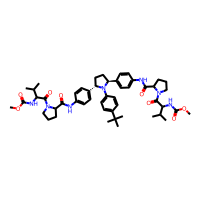
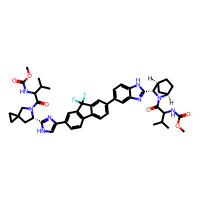
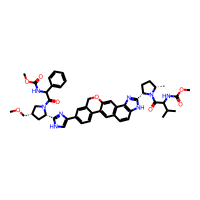
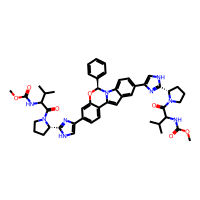
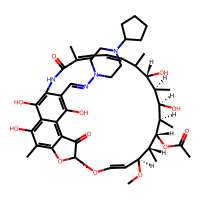

In [13]:
# Load CSV Data
data = pd.read_csv('data/drugbank5.1.13_approved_r1r10w900.csv')
PandasTools.AddMoleculeColumnToFrame(frame=data, smilesCol='smiles')
data = data.dropna(subset=["ROMol"])
data = data.reset_index(drop=True)
print(len(data))
data.head()

(1928, 8)


,DATABASE_ID,smiles,ROMol,nRing,QED,QEPPI,SAscore,SpacialScore
0,DB09296,COC(=O)NC(C(=O)N1CCCC1C(=O)Nc1ccc([C@@H]2CC[C@...,,6,0.133974,0.179430,4.636767,20.630769
1,DB09027,COC(=O)NC(C(=O)N1CC2(CC2)C[C@H]1c1nc(-c2ccc3c(...,,10,0.107881,0.153081,6.442558,22.923077
2,DB11613,COC[C@H]1C[C@@H](c2nc(-c3ccc4c(c3)COc3cc5c(ccc...,,9,0.100106,0.089567,5.270615,19.984615
3,DB11574,COC(=O)NC(C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2)O[C...,,9,0.099661,0.090453,5.142952,18.861538
4,DB01201,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(C=...,,7,0.092638,0.084423,7.279721,31.031746

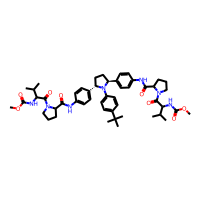
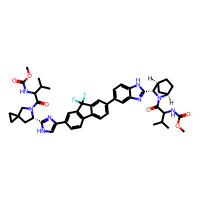
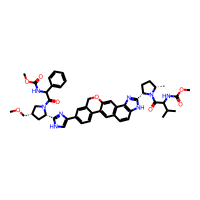
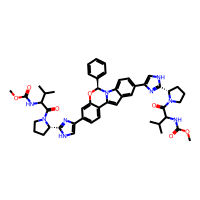
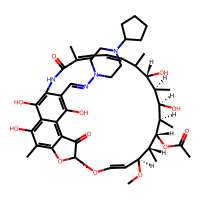

In [14]:
#Descriptor Calculation
data['nRing'] = data.ROMol.map(AllChem.CalcNumRings)
data['QED'] = data.ROMol.map(QED.qed)
data['QEPPI'] = data.ROMol.map(q.qeppi)
data['SAscore'] = data.ROMol.map(sascorer.calculateScore)
data["SpacialScore"] = data["ROMol"].apply(lambda x: compute_spacial_score(x))

print(data.shape)
data.head()

(1928, 10)


,DATABASE_ID,smiles,ROMol,nRing,QED,QEPPI,SAscore,SpacialScore,RCI,QRCI
0,DB09296,COC(=O)NC(C(=O)N1CCCC1C(=O)Nc1ccc([C@@H]2CC[C@...,,6,0.133974,0.179430,4.636767,20.630769,1.000000,3.196222
1,DB09027,COC(=O)NC(C(=O)N1CC2(CC2)C[C@H]1c1nc(-c2ccc3c(...,,10,0.107881,0.153081,6.442558,22.923077,1.243902,5.630581
2,DB11613,COC[C@H]1C[C@@H](c2nc(-c3ccc4c(c3)COc3cc5c(ccc...,,9,0.100106,0.089567,5.270615,19.984615,1.190476,4.649152
3,DB11574,COC(=O)NC(C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2)O[C...,,9,0.099661,0.090453,5.142952,18.861538,1.139535,4.502780
4,DB01201,CO[C@H]1/C=C/O[C@@]2(C)Oc3c(C)c(O)c4c(O)c(c(C=...,,7,0.092638,0.084423,7.279721,31.031746,1.853659,5.339679

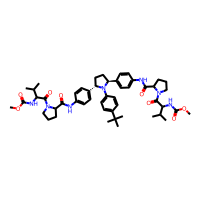
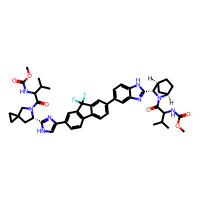
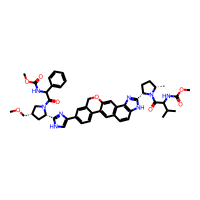
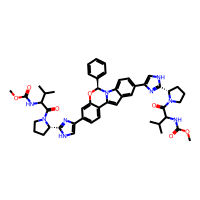
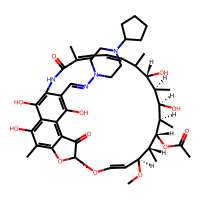

In [15]:
# calculate RCI & QRCI
data["RCI"] = data["ROMol"].apply(calculate_ring_complexity_index)

qrci_calc = QRCICalculator(weights='mean')
data['QRCI'] = data['ROMol'].apply(qrci_calc)
print(data.shape)
data.head()

In [16]:
qrci_calc = QRCICalculator(weights='max')
qrci_max = qrci_calc('C1=CCOCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc(c2)COC1')
print(f"QRCI(max weights): {qrci_max:.3f}")

QRCI(max weights): 4.058


In [17]:
qrci_calc = QRCICalculator(weights='mean')
qrci_mean = qrci_calc('C1=CCOCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc(c2)COC1')
print(f"QRCI(default/mean weights): {qrci_mean:.3f}")

QRCI(default/mean weights): 4.033


In [18]:
qrci_calc = QRCICalculator(weights='unit')
qrci_unit = qrci_calc('C1=CCOCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc(c2)COC1')
print(f"QRCI(unit weights): {qrci_unit:.3f}")

QRCI(unit weights): 4.016


In [19]:
#custom weights
custom_w = [1.0, 1.1, 1.2, 0.8, 0.9, 1.0]
qrci_custom = QRCICalculator(weights=custom_w)
score = qrci_custom('C1=CCOCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc(c2)COC1')
print(f"QRCI(custom weights): {qrci_unit:.3f}")

QRCI(custom weights): 4.016


In [20]:
#https://go.drugbank.com/drugs/DB11697
#calculate QRCIproperties
mol = Chem.MolFromSmiles('C1=CCOCc2cc(ccc2OCCN2CCCC2)Nc2nccc(n2)-c2cccc(c2)COC1')
props = get_QRCIproperties(mol)
print(props)

QRCIproperties(nAromHetero=1, nAromCarbo=2, nAliHetero=2, nAliCarbo=0, nSatHetero=1, nSatCarbo=0, nMacrocycles=1, TRS=41, nRingAtom=32, nFusedRing=4, SF=1.0857142857142856)


In [21]:
def create_qrci_radar_plot(qrci_properties, min_values, max_values, 
                           title="QRCI Radar Plot", color="#89319C", 
                           save_path=None, dpi=600):
    """
    Draws a radar chart for QRCI properties with normalization, clean styling, and optional image saving.

    Args:
        qrci_properties (namedtuple): Contains the 11 QRCI properties.
        min_values (list): Minimum bounds for normalization (same length as properties).
        max_values (list): Maximum bounds for normalization.
        title (str): Title shown on the radar plot.
        color (str): Fill color for the radar area.
        save_path (str): If provided, saves the figure to this path (e.g. "output.png").
        dpi (int): Resolution of saved image (default: 600 dpi).
    """
    # Convert namedtuple to dictionary
    qrci_dict = qrci_properties._asdict()

    # Extract property names and values
    properties = list(qrci_dict.keys())
    values = list(qrci_dict.values())

    # Normalize values to range [0, 1]
    normalized_values = [
        (v - min_v) / (max_v - min_v) if max_v - min_v != 0 else 0
        for v, min_v, max_v in zip(values, min_values, max_values)
    ]
    normalized_values += normalized_values[:1]  # close the loop
    angles = np.linspace(0, 2 * np.pi, len(properties), endpoint=False).tolist()
    angles += angles[:1]

    # Create radar chart
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={'projection': 'polar'})
    ax.fill(angles, normalized_values, color=color, alpha=0.6)
    ax.plot(angles, normalized_values, color=color, linewidth=1)

    # Add value labels only if non-zero
    for i, (angle, val) in enumerate(zip(angles[:-1], normalized_values[:-1])):
        if values[i] != 0:
            ax.text(angle, val + 0.05, f"{values[i]:.1f}", ha='center', va='center', fontsize=6)

    # Axis styling
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(properties, fontsize=9)
    ax.set_yticks([0.5, 1])
    ax.set_yticklabels([])  # Hide radial labels
    ax.set_ylim(0, 0.8)
    ax.xaxis.set_tick_params(pad=20)
    ax.grid(True, linestyle='--', linewidth=0.4)

    # Add title if provided
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold', pad=10)

    # Adjust layout
    plt.tight_layout()

    # Save image if requested
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')

    # Display the plot
    plt.show()

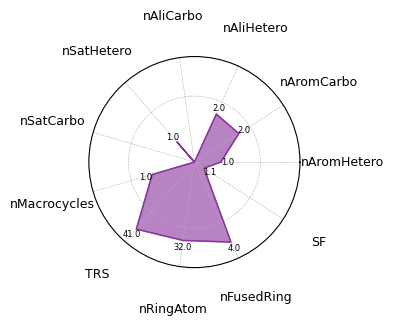

In [22]:
min_values = [0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 1]
max_values = [5, 5, 5, 3, 5, 3, 3, 60, 50, 6, 2]
create_qrci_radar_plot(props, min_values, max_values, "", "#89319C", save_path="figs/qrci_radar_plot.png", dpi=600)

QRCIproperties(nAromHetero=2, nAromCarbo=4, nAliHetero=3, nAliCarbo=0, nSatHetero=1, nSatCarbo=0, nMacrocycles=0, TRS=52, nRingAtom=35, nFusedRing=8, SF=2.329365079365079)


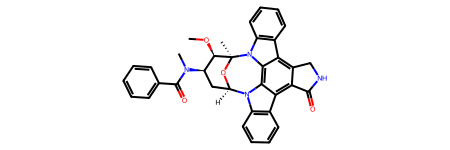

In [23]:
#https://go.drugbank.com/drugs/DB06595
Midostaurin = Chem.MolFromSmiles('CO[C@@H]1[C@@H](C[C@H]2O[C@]1(C)N1C3=C(C=CC=C3)C3=C1C1=C(C4=C(C=CC=C4)N21)C1=C3CNC1=O)N(C)C(=O)C1=CC=CC=C1')
Midostaurin_props = get_QRCIproperties(Midostaurin)
print(Midostaurin_props)
Midostaurin

In [24]:
Midostaurin_score_mean = qrci_calc('COC1=NC2=C(C=C(Br)C=C2)C=C1[C@@H](C1=CC=CC=C1)[C@@](O)(CCN(C)C)C1=CC=CC2=C1C=CC=C2')
print(f"QRCI(default/mean weights): {Midostaurin_score_mean:.4f}")

QRCI(default/mean weights): 3.6530


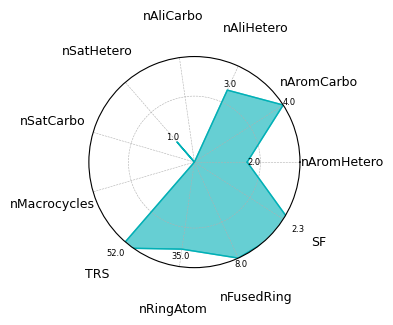

In [25]:
min_values = [0, 0, 0, 0, 0, 0, 0, 2, 5, 0, 1]
max_values = [5, 5, 5, 3, 5, 3, 3, 60, 50, 10, 2.5]
create_qrci_radar_plot(Midostaurin_props, min_values, max_values, "", "#00b0b6", save_path="figs/qrci_radar_Midostaurin.png", dpi=600)

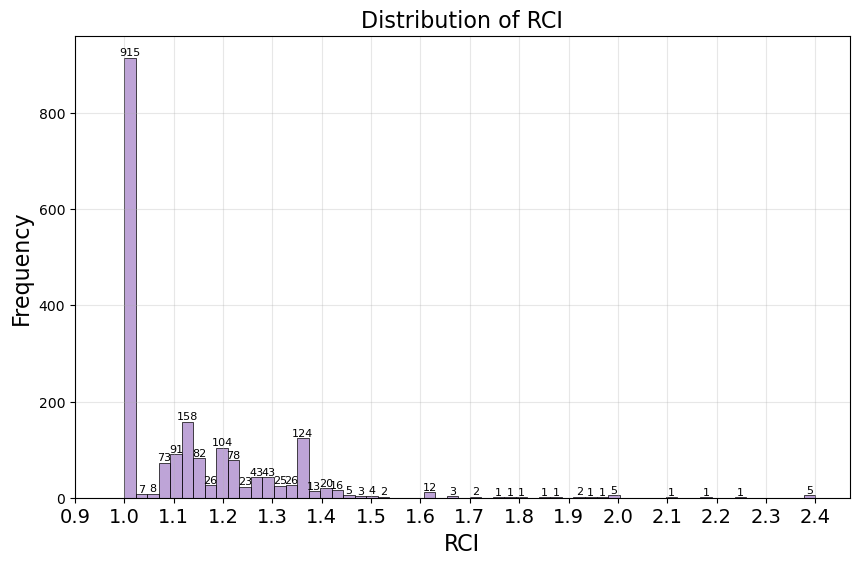

In [26]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data['RCI'], label="RCI", bins=60, color="#9467BD", 
                  edgecolor="black", kde=False, alpha=0.6, linewidth=0.5)
plt.xticks(np.arange(0.9, 2.5, 0.1), fontsize=14)
plt.title("Distribution of RCI", fontsize=16)
plt.xlabel("RCI", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.grid(alpha=0.3)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, height, int(height),
                 ha='center', va='bottom', fontsize=8)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_rci_histdist.png', dpi=300)
plt.show()

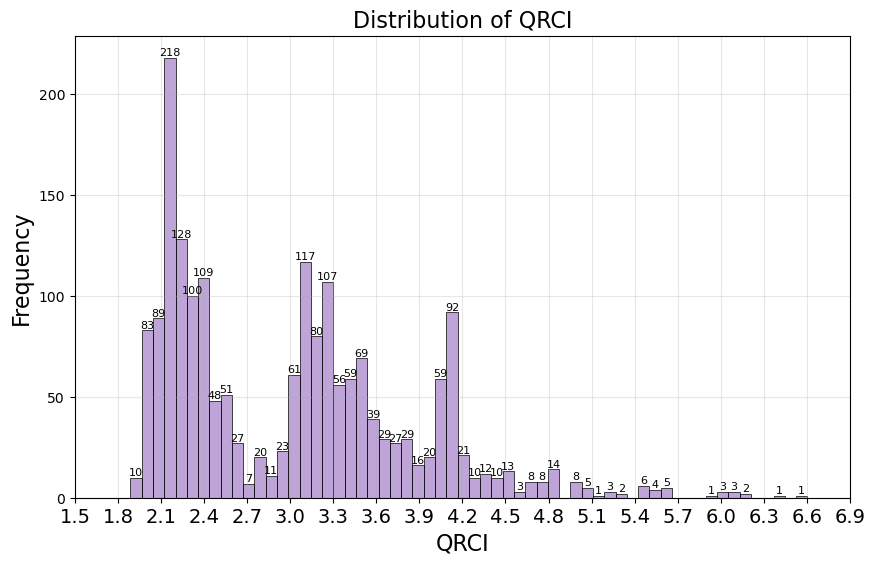

In [27]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(data['QRCI'], label="QRCI", bins=60, color="#9467BD", 
                  edgecolor="black", kde=False, alpha=0.6, linewidth=0.5)
plt.xticks(np.arange(1.5, 7, 0.3), fontsize=14)
plt.title("Distribution of QRCI", fontsize=16)
plt.xlabel("QRCI", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.grid(alpha=0.3)

for patch in ax.patches:
    height = patch.get_height()
    if height > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, height, int(height),
                 ha='center', va='bottom', fontsize=8)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_qrci_histdist.png', dpi=300)
plt.show()

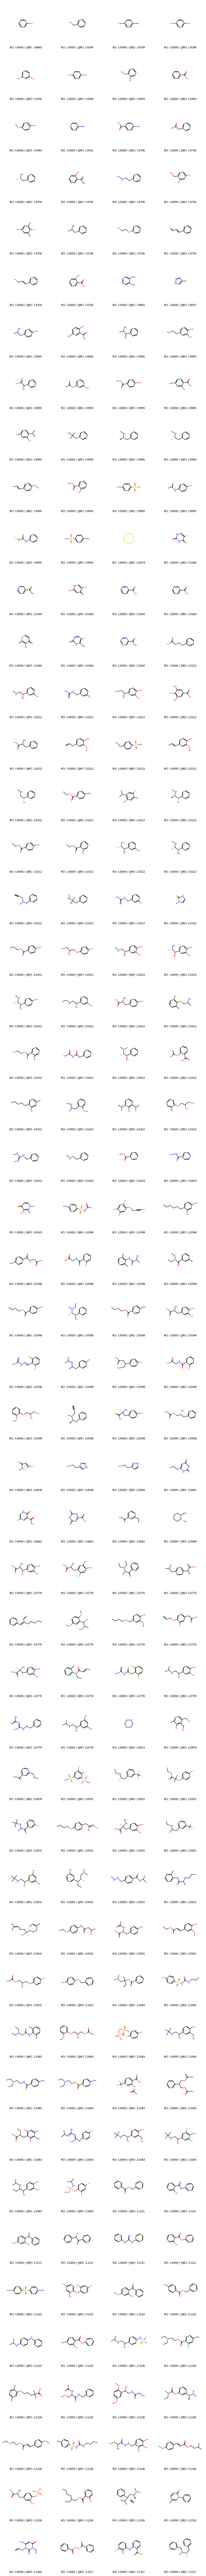

In [28]:
data = data.sort_values(by="QRCI")
Draw.MolsToGridImage(data.ROMol[:200], 
                     legends=[f"RCI: {r:.4f} | QRCI: {q:.4f}" for r, q in zip(data['RCI'][:200], data['QRCI'][:200])], 
                     molsPerRow=4, 
                     subImgSize=(300, 300), 
                     maxMols=200)

Wilcoxon signed-rank test - RCI vs QRCI: statistic = 0.0000, p-value = 0.0000
RCI vs QRCI: Significant difference


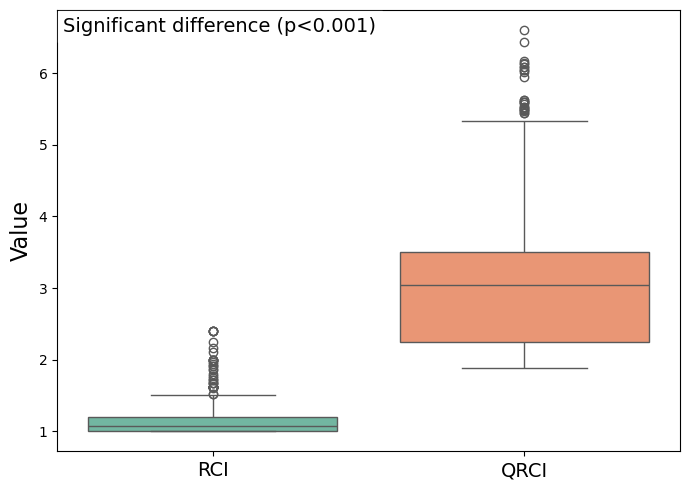

In [29]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test
stat_wilcoxon, p_value_wilcoxon = wilcoxon(data['RCI'], data['QRCI'])

# Print test statistic and p-value
print(f"Wilcoxon signed-rank test - RCI vs QRCI: statistic = {stat_wilcoxon:.4f}, p-value = {p_value_wilcoxon:.4f}")

# Check significance
def check_significance(p_value, threshold=0.05):
    return "Significant difference" if p_value < threshold else "No significant difference"

print(f"RCI vs QRCI: {check_significance(p_value_wilcoxon)}")

# Customize fonts for visualization
title_font = {'fontsize': 16, 'fontweight': 'normal'}
label_font = {'fontsize': 16, 'fontweight': 'normal'}
tick_fontsize = 14

# Plot the comparison
plt.figure(figsize=(7, 5))
sns.boxplot(data=[data['RCI'], data['QRCI']], palette="Set2")
plt.xticks([0, 1], ['RCI', 'QRCI'], fontsize=tick_fontsize)
plt.ylabel('Value', **label_font)

# Annotate significance
plt.text(
    0.01, 0.95, f'Significant difference (p<0.001)', 
    transform=plt.gca().transAxes, fontsize=14, fontweight='normal',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='white')
)

plt.tight_layout()
# plt.savefig("figures/drugbank5.1.13_apvd_r1r10w900_rci_qrci_Wilcoxon_test.png", dpi=300)
plt.show()

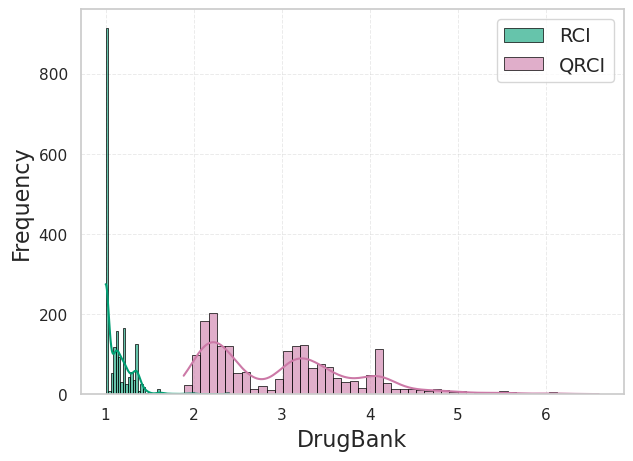

In [30]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))

sns.histplot(data["RCI"], label="RCI", bins=50, color="#009E73", edgecolor="black", kde=True, alpha=0.6, linewidth=0.5)
sns.histplot(data['QRCI'], label="QRCI", bins=50, color="#CC79A7", edgecolor="black", kde=True, alpha=0.6, linewidth=0.5)

#plt.title("Histogram of RCI and QRCI", fontsize=16)
plt.xlabel("DrugBank", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.legend(fontsize=14)
plt.grid(alpha=0.4, linestyle="--", linewidth=0.7)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_rci_qrci_binsdist.png', dpi=300)
plt.show()

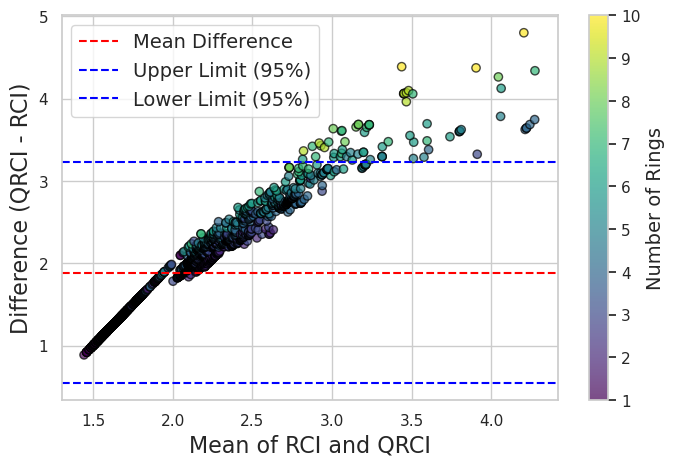

In [31]:
# Compute Bland-Altman values
mean_diff = (data["QRCI"] + data["RCI"]) / 2
diff = data["QRCI"] - data["RCI"]
mean_diff_line = np.mean(diff)
std_diff = np.std(diff, ddof=1)

# Create Bland-Altman Plot colored by number of rings (nRing)
plt.figure(figsize=(8, 5))
scatter = plt.scatter(mean_diff, diff, c=data["nRing"], cmap="viridis", alpha=0.7, edgecolors="black")

# Add mean and confidence limits
plt.axhline(mean_diff_line, color='red', linestyle='--', label="Mean Difference")
plt.axhline(mean_diff_line + 1.96 * std_diff, color='blue', linestyle='--', label="Upper Limit (95%)")
plt.axhline(mean_diff_line - 1.96 * std_diff, color='blue', linestyle='--', label="Lower Limit (95%)")

# Labels and title
plt.xlabel("Mean of RCI and QRCI", fontsize=16)
plt.ylabel("Difference (QRCI - RCI)", fontsize=16)
#plt.title("Bland-Altman Plot for RCI vs. QRCI (Colored by nRing)", fontsize=14)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label("Number of Rings", fontsize=14)

plt.legend(loc="upper left", fontsize=14)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_rci_qrci_Bland-Altman.png', dpi=300)
plt.show()

In [32]:
# Compute entropy (adding a small value to avoid zero probability bins)
hist_rci, _ = np.histogram(data['RCI'], bins=30, density=True)
hist_qrci, _ = np.histogram(data['QRCI'], bins=30, density=True)
entropy1 = stats.entropy(hist_rci + 1e-10)  # Avoid log(0)
entropy2 = stats.entropy(hist_qrci + 1e-10)

# Compute kurtosis
kurtosis1 = stats.kurtosis(data['RCI'])
kurtosis2 = stats.kurtosis(data['QRCI'])

# Compute skewness
skewness1 = stats.skew(data['RCI'])
skewness2 = stats.skew(data['QRCI'])

# Print metrics
print(f"RCI - Entropy: {entropy1:.4f}, Kurtosis: {kurtosis1:.4f}, Skewness: {skewness1:.4f}")
print(f"QRCI - Entropy: {entropy2:.4f}, Kurtosis: {kurtosis2:.4f}, Skewness: {skewness2:.4f}")

RCI - Entropy: 1.8370, Kurtosis: 11.7988, Skewness: 2.5893
QRCI - Entropy: 2.7402, Kurtosis: 0.4895, Skewness: 0.8422


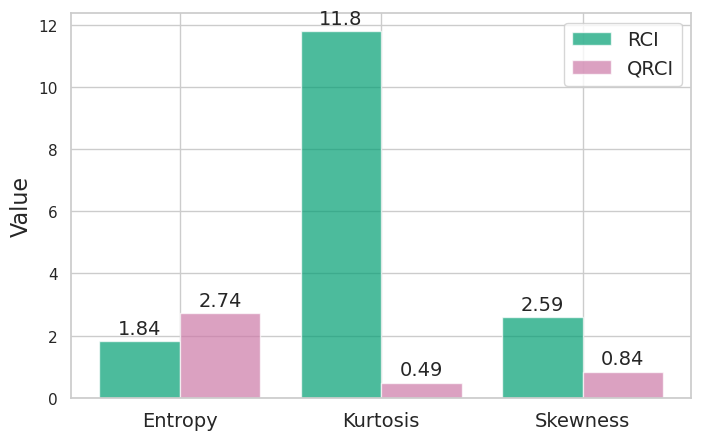

In [33]:
# Data for visualization
metrics = ["Entropy", "Kurtosis", "Skewness"]
rci_values = [1.8370, 11.7988, 2.5893]
qrci_values = [2.7402, 0.4895, 0.8422]

# Create a grouped bar plot
fig, ax = plt.subplots(figsize=(8, 5))
bar_width = 0.4
index = np.arange(len(metrics))

bars1 = ax.bar(index, rci_values, bar_width, label="RCI", color="#009E73", alpha=0.7)
bars2 = ax.bar(index + bar_width, qrci_values, bar_width, label="QRCI", color="#CC79A7", alpha=0.7)

# Add labels and title
#ax.set_xlabel("Statistical Metrics", fontsize=16)
ax.set_ylabel("Value", fontsize=16)
#ax.set_title("Comparison of Statistical Metrics for RCI and QRCI", fontsize=14)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics, fontsize=14)
ax.legend(fontsize=14)

# Display values on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), 
                ha='center', va='bottom', fontsize=14, fontweight='normal')

#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_rci_qrci_difference_dist.png', dpi=300)
# Show the plot
plt.show()

Pearson Correlation: 0.52
Spearman Correlation: 0.49


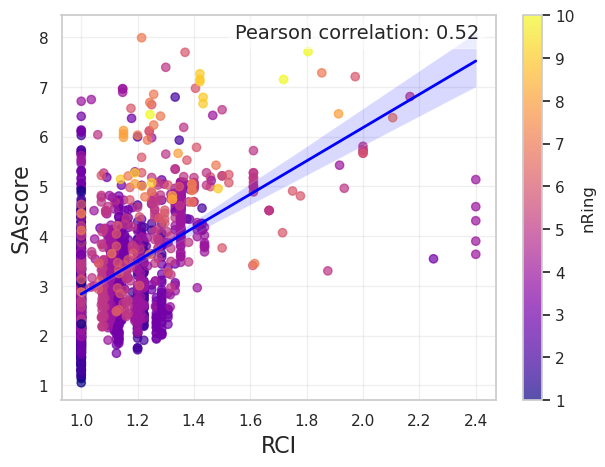

In [34]:
pearson_corr, _ = pearsonr(data["RCI"], data["SAscore"])
spearman_corr, _ = spearmanr(data["RCI"], data["SAscore"])
print(f"Pearson Correlation: {pearson_corr:.2f}")
print(f"Spearman Correlation: {spearman_corr:.2f}")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
scatter = plt.scatter(data["RCI"], data["SAscore"], c=data["nRing"], cmap="plasma", alpha=0.7)
plt.colorbar(scatter, label="nRing")
cbar.ax.set_ylabel("nRing", fontsize=14)
sns.regplot(x="RCI", y="SAscore", data=data, scatter=False, color="blue", line_kws={"linewidth":2})

plt.text(
    0.4, 0.94, 
    f'Pearson correlation: {pearson_corr:.2f}', 
    transform=plt.gca().transAxes, 
    fontsize=14, fontweight='normal', 
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='white')
)

#plt.title("RCI vs SAscore with Regression Line", fontsize=16)
plt.xlabel("RCI", fontsize=16)
plt.ylabel("SAscore", fontsize=16)
plt.grid(alpha=0.3)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_sa_rci.png', dpi=300)
plt.show()

Pearson Correlation: 0.57
Spearman Correlation: 0.50


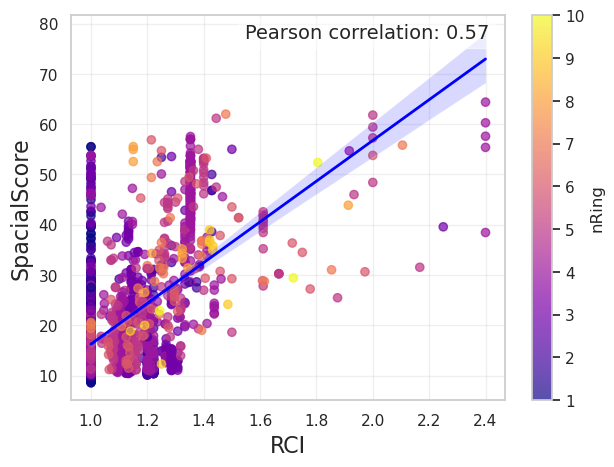

In [35]:
pearson_corr, _ = pearsonr(data["RCI"], data["SpacialScore"])
spearman_corr, _ = spearmanr(data["RCI"], data["SpacialScore"])
print(f"Pearson Correlation: {pearson_corr:.2f}")
print(f"Spearman Correlation: {spearman_corr:.2f}")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
scatter = plt.scatter(data["RCI"], data["SpacialScore"], c=data["nRing"], cmap="plasma", alpha=0.7)
plt.colorbar(scatter, label="nRing")
cbar.ax.set_ylabel("nRing", fontsize=14)
sns.regplot(x="RCI", y="SpacialScore", data=data, scatter=False, color="blue", line_kws={"linewidth":2})

plt.text(
    0.4, 0.94, 
    f'Pearson correlation: {pearson_corr:.2f}', 
    transform=plt.gca().transAxes, 
    fontsize=14, fontweight='normal', 
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='white')
)

#plt.title("RCI vs SpacialScore with Regression Line", fontsize=16)
plt.xlabel("RCI", fontsize=16)
plt.ylabel("SpacialScore", fontsize=16)
plt.grid(alpha=0.3)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_sps_rci.png', dpi=300)
plt.show()

Pearson Correlation: 0.66
Spearman Correlation: 0.63


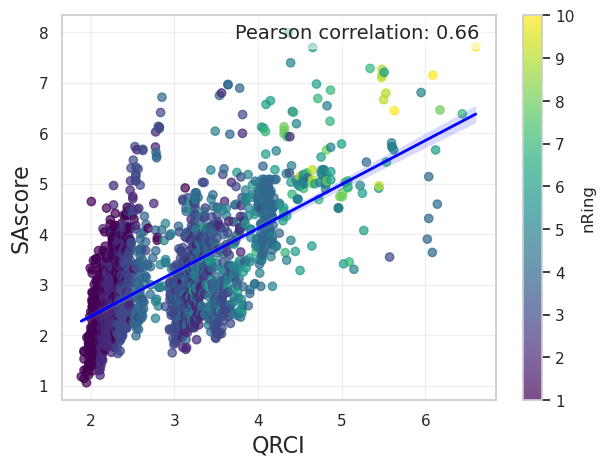

In [36]:
pearson_corr, _ = pearsonr(data["QRCI"], data["SAscore"])
spearman_corr, _ = spearmanr(data["QRCI"], data["SAscore"])
print(f"Pearson Correlation: {pearson_corr:.2f}")
print(f"Spearman Correlation: {spearman_corr:.2f}")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
scatter = plt.scatter(data["QRCI"], data["SAscore"], c=data["nRing"], cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="nRing")
cbar.ax.set_ylabel("nRing", fontsize=14)
sns.regplot(x="QRCI", y="SAscore", data=data, scatter=False, color="blue", line_kws={"linewidth":2})

plt.text(
    0.4, 0.94, 
    f'Pearson correlation: {pearson_corr:.2f}', 
    transform=plt.gca().transAxes, 
    fontsize=14, fontweight='normal', 
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='white')
)

#plt.title("QRCI vs SAscore with Regression Line", fontsize=16)
plt.xlabel("QRCI", fontsize=16)
plt.ylabel("SAscore", fontsize=16)
plt.grid(alpha=0.3)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_sa_qrci.png', dpi=300)
plt.show()

Pearson Correlation: 0.62
Spearman Correlation: 0.64


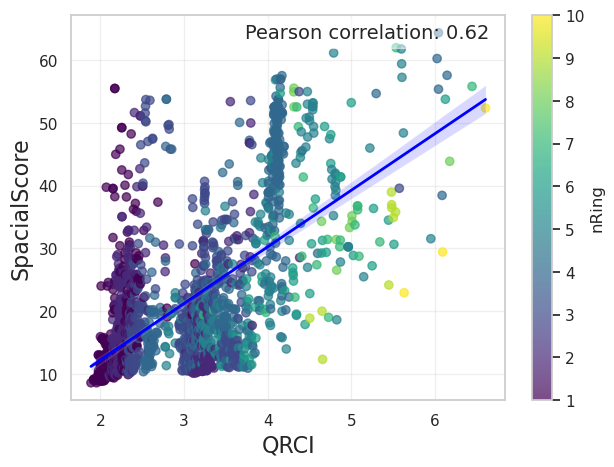

In [37]:
pearson_corr, _ = pearsonr(data["QRCI"], data["SpacialScore"])
spearman_corr, _ = spearmanr(data["QRCI"], data["SpacialScore"])
print(f"Pearson Correlation: {pearson_corr:.2f}")
print(f"Spearman Correlation: {spearman_corr:.2f}")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(7, 5))
scatter = plt.scatter(data["QRCI"], data["SpacialScore"], c=data["nRing"], cmap="viridis", alpha=0.7)
plt.colorbar(scatter, label="nRing")
cbar.ax.set_ylabel("nRing", fontsize=14)
sns.regplot(x="QRCI", y="SpacialScore", data=data, scatter=False, color="blue", line_kws={"linewidth":2})

plt.text(
    0.4, 0.94, 
    f'Pearson correlation: {pearson_corr:.2f}', 
    transform=plt.gca().transAxes, 
    fontsize=14, fontweight='normal', 
    bbox=dict(facecolor='white', alpha=0.5, edgecolor='white')
)

#plt.title("QRCI vs SpacialScore with Regression Line", fontsize=16)
plt.xlabel("QRCI", fontsize=16)
plt.ylabel("SpacialScore", fontsize=16)
plt.grid(alpha=0.3)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_sps_qrci.png', dpi=300)
plt.show()

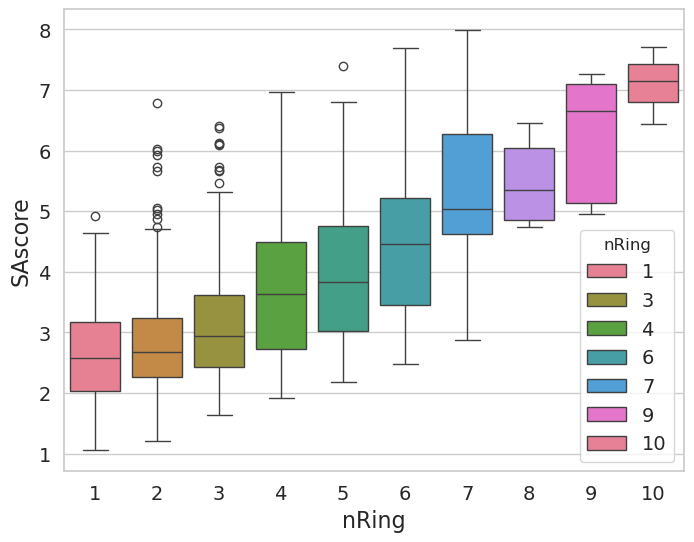

In [38]:
# Plot the distribution of SAscore grouped by NumRings
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['nRing'], y=data['SAscore'], hue=data['nRing'], palette="husl")
#plt.title('Distribution of SAscore grouped by nRing', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('nRing', fontsize=16)
plt.ylabel('SAscore', fontsize=16)
plt.legend(title='nRing', loc='lower right', bbox_to_anchor=(1, 0), fontsize=14)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_nring_sa_dist.png', dpi=300)
plt.show()

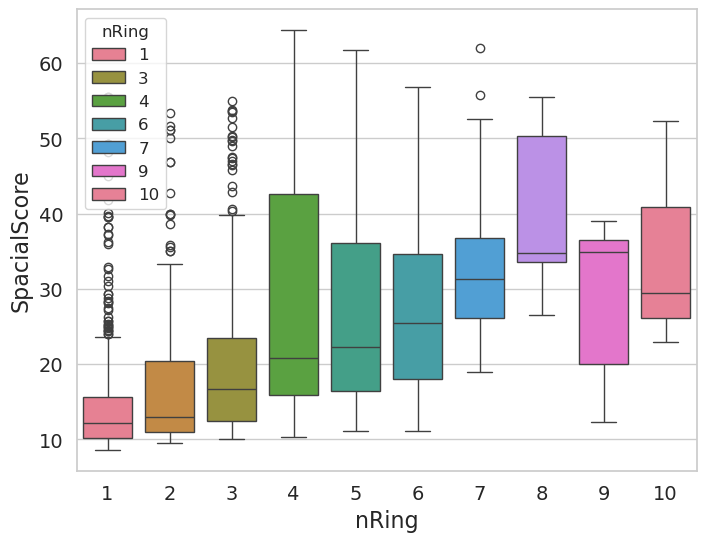

In [39]:
# Plot the distribution of SpacialScore grouped by NumRings
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['nRing'], y=data['SpacialScore'], hue=data['nRing'], palette="husl")
#plt.title('Distribution of SpacialScore grouped by nRing', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('nRing', fontsize=16)
plt.ylabel('SpacialScore', fontsize=16)
plt.legend(title='nRing', loc='upper left', bbox_to_anchor=(0, 1), fontsize=12)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_nring_sps_dist.png', dpi=300)
plt.show()

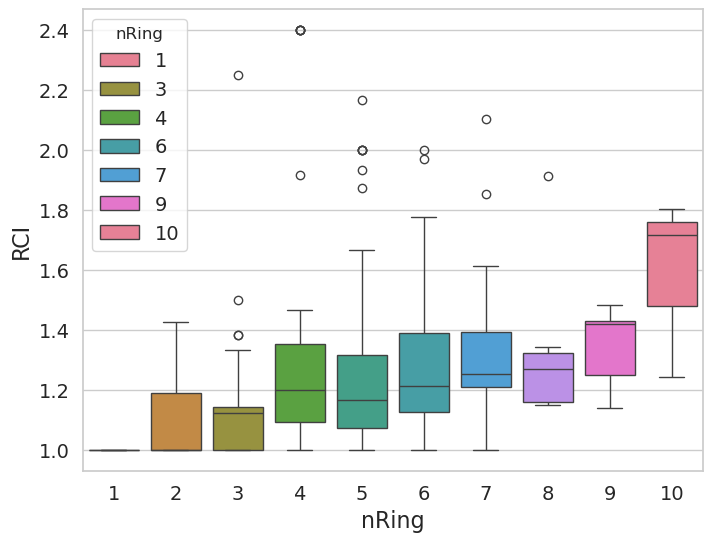

In [40]:
# Plot the distribution of RCI grouped by NumRings
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['nRing'], y=data['RCI'], hue=data['nRing'], palette="husl")
#plt.title('Distribution of RCI grouped by nRing', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('nRing', fontsize=16)
plt.ylabel('RCI', fontsize=16)
plt.legend(title='nRing', loc='upper left', bbox_to_anchor=(0, 1), fontsize=14)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_nring_rci_dist.png', dpi=300)
plt.show()

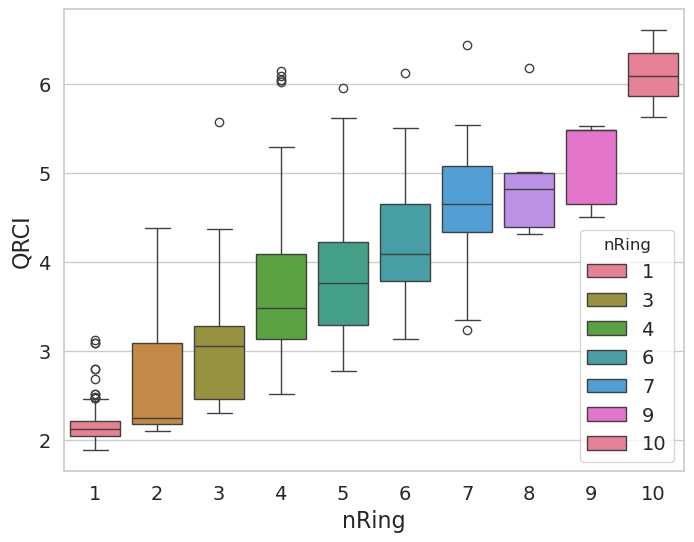

In [41]:
# Plot the distribution of QRCI grouped by NumRings
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['nRing'], y=data['QRCI'], hue=data['nRing'], palette="husl")
#plt.title('Distribution of QRCI grouped by nRing', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('nRing', fontsize=16)
plt.ylabel('QRCI', fontsize=16)
plt.legend(title='nRing', loc='lower right', bbox_to_anchor=(1, 0), fontsize=14)
#plt.savefig('figures/drugbank5.1.13_apvd_r1r10w900_nring_qrci_dist.png', dpi=300)
plt.show()